# CESM-LE analysis
### Looks and changes in iWUE over time
 - reading in ensemble of data from CESM1_LENS, CESM2_LENS, and CESM2-CMIP5 a relatively large dataset 
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2020.12.0
dask.__version__

'2021.01.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 18
nmem   = str(int(375*ncores/ncores))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [8]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

Client Scheduler: tcp://10.12.205.30:38321 Dashboard: http://10.12.205.30/proxy/8787/status,Cluster Workers: 18 Cores: 18 Memory: 374.94 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [9]:
def get_file(ee,model,field,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        firstyear = 10*int(yr/10)
        yy    = '.'+str(firstyear)+'01-'+str(firstyear+9)+'12.'
        if yr>2009:
            yy = '.201001-201412.'
        ff     = glob.glob(mm+lnd+'*.h0.'+field+yy+'*')[0]
    return ff

In [10]:
def all_files(model,field,firstyear, nens):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        #nens = 42
        files = [get_file(ee,'CESM1',field,0) for ee in range(nens)]
    else:
        #nens = 50
        yrs = [*np.arange(firstyear,2009,10),2010]
        files = [[get_file(ee,'CESM2',field,yr) for yr in yrs] 
                 for ee in range(nens)]
    return files

In [11]:
def get_monthly(model,fields,firstyear, nens, chunks={'time':500}):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear, nens)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                ds = xr.open_mfdataset(files[0],combine='by_coords',parallel=True,chunks=chunks)
                tmp = xr.open_dataset(files[0][0])
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0],chunks=chunks)

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model],chunks=chunks)
        ds[field] = tmp[field]

    ds['landarea'] = ds['area']*ds['landfrac']
    ds['landarea'].name = 'landarea'
    ds['landarea'].attrs['units'] = 'km2'
        
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [12]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [13]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### Actually read the data in here
- method 1, Ecosystem WUE, as in Keenan et al. 2013
  - iWUE = GPP*VPD/ET 
- method 2, leaf level estimate.  
  - iWUE = GPP/(GSSUN*LAISUN + GSSHA*LAISHA)
  - Bug in calculation of GS w/ LULCC make this problematic
  
-- TODO, code fails on calculation of iWUE w/ 30 ensemble members.

In [14]:
%%time
WUEmethod = 1

if WUEmethod == 1:
    data_vars = ['QVEGT','GPP','TBOT','RH2M','TOTVEGC'] #,'QVEGE','QSOIL'
else:
    # We wont' use this approach because of errors in how grid cell averages for GS was calculated with LULCC
    data_vars = ['GPP','GSSUN','GSSHA','LAISUN','LAISHA','TOTVEGC']

model = 'CESM2'
firstyear = 1970
nens = 10  # read in 10 ensemble members for now
ds = get_monthly(model,data_vars,firstyear, nens)

CPU times: user 9 s, sys: 2.03 s, total: 11 s
Wall time: 14.7 s


In [15]:
# mask out grids where max(GPP = 0)
# do we need to calculate iWUE in months over a threshold GPP (or ET)?
ds = ds.where(ds['GPP'].max(['time','ens'])> 0.)

# this masks all month w/ 0 GPP
#minGPP = 0
# for i in range(len(data_vars)):
#    ds[data_vars[i]] = ds[data_vars[i]].where(ds['GPP']> minGPP)

t = np.unique(ds['time.year'])

In [16]:
#mask out absurd GSSHA values that crop up some times...
if WUEmethod == 2:
    
    temp = ds.GSSHA.sel(lat=25, lon=100, method='nearest').transpose('time','ens')
    plt.plot(temp);
    #ds['GSSHA'] = ds.GSSHA.where(ds['GSSHA']<1e8)
    ds['GSSHA'] = ds.GSSHA.where(ds.GSSHA < (2*ds.GSSUN.max()) )  #all GSSHA < 2*max(GSSUN)
    #ds = ds.where(ds['LAISUN'].max(['time','ens'])> 0.)

## Esimate of VPD
- This is using monthly data, which may be less accurate...

In [17]:
%%time
if WUEmethod == 1:
    lv  = 2.5e6  ;
    rv  = 461    ;
    es  = 611*np.exp(lv/rv*(1/273.16-1/ds['TBOT']));
    ds['VPD'] = (1-ds['RH2M']/100)*es;
    # check that units are correct, need to devide by 100 to convert to hPa?
    ds['VPD'] = (ds['VPD'] / 100).compute(skipna=True) 
    ds['VPD'].attrs['units'] = 'hPa'
    ds['VPD'].attrs['long_name'] = 'Vapor Pressure Deficit, derived from monthly data'

    #### Here using ET as sum of transpiration and evaporation fluxes
    # mm/s = kg/m2/s
    ds['ET'] = (ds.QVEGT).load() #+ ds.QVEGE + ds.QSOIL
else:
    # Canopy conductance (umol H2O/m2 leaf area is, converted to m2 ground area)
    ds['GS'] = ((ds.GSSHA*ds.LAISHA) + (ds.GSSUN*ds.LAISUN)).compute(skipna=True) #umol H2O/m2/s

CPU times: user 2.91 s, sys: 17 s, total: 19.9 s
Wall time: 51.9 s


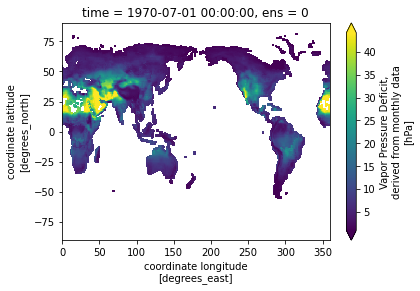

In [18]:
ds['VPD'].isel(time=6,ens=0).plot(robust=True);

### Now calculate iWUE 
- This is really slow and fails with more ensemble members (20+)
- Looping calculations over ensemble members for memory also slow
- **TODO, make this more efficient!**

In [19]:
%%time

ds['iWUE'] = (ds.GPP*ds.VPD/ds.ET).compute(skipna=True)
ds.iWUE.attrs['long_name'] = 'Intrinsic water use efficiency'

if WUEmethod == 1:
    ds.iWUE.attrs['units'] = '(gC/kg H2O) hPa'

print('-- Finished iWUE calculations -- ')

-- Finished iWUE calculations -- 
CPU times: user 12.9 s, sys: 59 s, total: 1min 11s
Wall time: 4min 44s


### Mask out high iWUE to avoid skewing annual values
- coud also set min ET threshold, not currently used 

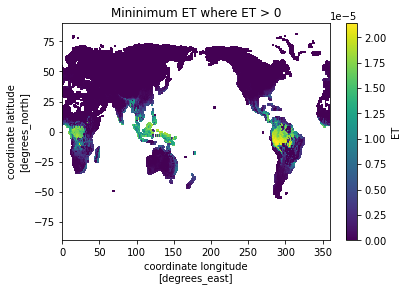

In [20]:
ds.ET.where(ds.ET>0).min(dim='time').sel(ens=0).plot()
plt.title('Mininimum ET where ET > 0');

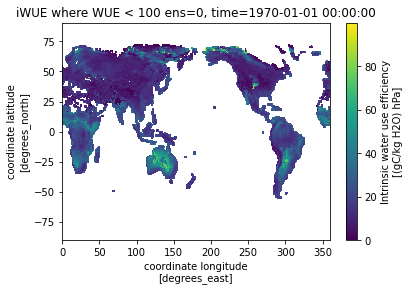

In [21]:
minWUE, maxWUE = 0, 100
ds['iWUE2'] = ds.iWUE.where(ds.iWUE >minWUE)
ds['iWUE2'] = ds.iWUE2.where(ds.iWUE<maxWUE).compute(skipna=True)

#minET = 1e-10
#ds['iWUE2'] = ds.iWUE.where(ds.ET>minET).compute(skipna=True)

ds.iWUE2.isel(time=0,ens=0).plot(robust=False);
plt.title('iWUE where WUE < '+str(maxWUE)+' ens=0, time='+str(ds.time[0].values)) ;

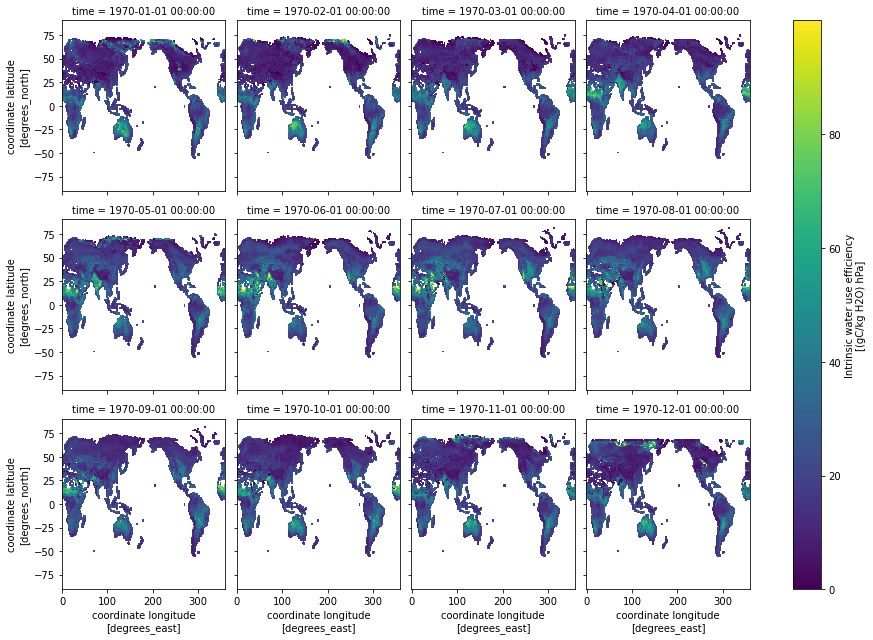

In [22]:
simple = ds.iWUE2.isel(time=slice(0,12),ens=0).plot(x='lon', y='lat', col='time', col_wrap=4);

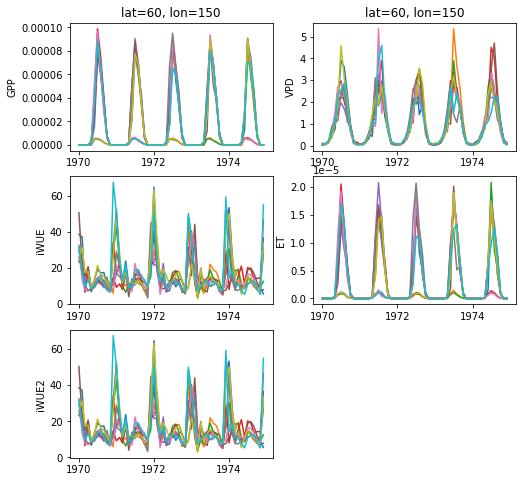

In [23]:
# Look at effects of masking on a single grid
#plt.plot(ds.iWUE.isel(ens=0).sel(lat=50, lon=50, method='nearest'))
plt.figure(figsize=[8,8])
plotVars = ['GPP','VPD','iWUE','ET','iWUE2']
tlat, tlon = 60,150 # 45,260 #50,50 #15,25 #50,300
for i in range(len(plotVars)):
    plt.subplot(3,2,(i+1))
    for j in range(nens):
        plt.plot(ds.time.isel(time=slice(0,60)), 
                 ds[plotVars[i]].isel(ens=j,time=slice(0,60)).sel(lat=tlat, lon=tlon, method='nearest'))
    if i<=1: plt.title('lat='+str(tlat)+', lon='+str(tlon));
        
    plt.ylabel(plotVars[i]);

### Calculate annual gridded and global results
- iWUE2 masked where values are not 0 or absurd.
- Because of missing values, iWUE2 is not weighted by days / month
- global results weighted so only looking at vegetated grid cells

In [24]:
## set up calculations

landarea = 1e6*(ds['area']*ds['landfrac']) # km2 -> m2
landarea = landarea.where(ds['GPP'].max(dim=['ens','time'])>0.) # mask out zero productivity grids
landwgt  = landarea/landarea.sum()

nyears   = len(np.unique(ds['time.year'])) 
xf1      = 24*60*60   # secs->days
xf2      = 1e-15      # gC->PgC, or Kg->Tt
xf3      = 1e-6*18.015 # umol H20 ->g H20

days_pm    = [31,28,31,30,31,30,31,31,30,31,30,31]

# Creaete long names and units for each variable to sum / average
plotVars = ['GPP',              'VPD',            'ET',      'iWUE',         'iWUE2']
varType  = ['sum',              'WGTmean',        'sum',     'WGTmean',      'mean']
grid_unit = ['gC/y',            'hPa',            'mm/s',    'gC/kg H2O hPa','gC/kg H2O hPa']
glob_unit = ['Pg C/y',          'hPa',            'Tt H2O/y','gC/kg H2O hPa','gC/kg H2O hPa']
grid_long = ['Annual GPP',      'Annual VPD',     'Annual ET',
             'Annual iWUE',     'masked Annual (0<iWUE<100)']
glob_long = ['Global sum GPP',  'Global mean VPD','Global sum ET',
             'Global mean iWUE','Global mean ('+str(minWUE)+'<iWUE<'+str(maxWUE)+')']

# Create datasets to hold output
ann_grid = xr.Dataset(ds.GPP.groupby('time.year').sum().coords)
ann = xr.Dataset(ann_grid.sum(dim=['lat','lon']).coords)
print(ann_grid)

<xarray.Dataset>
Dimensions:  (ens: 10, lat: 192, lon: 288, year: 45)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9
  * year     (year) int64 1970 1971 1972 1973 1974 ... 2010 2011 2012 2013 2014
Data variables:
    *empty*


In [25]:
# loop over variables to calculate annual fluxes

for i in range(len(plotVars)):
    print('starting '+plotVars[i])
    if varType[i] == 'sum': # grid weighted by days / month, global sum over land area
        #add skipna=True to sum() and .mean() calculations
        ann_grid[plotVars[i]] = xf1*(month_wts(nyears)*ds[plotVars[i]]).groupby('time.year').sum() 
        ann[plotVars[i]] = xf2*(landarea*ann_grid[plotVars[i]]).sum(dim=['lat','lon']) 
       
    if varType[i] == 'WGTmean': # grid weighted by days / month, global weighted by area
        ann_grid[plotVars[i]] = (month_wts(nyears)/365*ds[plotVars[i]]).groupby('time.year').sum() 
        ann[plotVars[i]] = (landwgt*ann_grid[plotVars[i]]).sum(dim=['lat','lon'],skipna=True) 
        
    if varType[i] == 'mean':  # grid NOT weighted by days / month, global weighted by area
        ann_grid[plotVars[i]] = ds[plotVars[i]].groupby('time.year').mean().transpose('year','ens','lat','lon') 
        ann[plotVars[i]] = (landwgt*ann_grid[plotVars[i]]).sum(dim=['lat','lon']).transpose('year','ens') 

    ann_grid[plotVars[i]].attrs['long_name'] = grid_long[i]
    ann_grid[plotVars[i]].attrs['units'] = grid_unit[i]
    ann[plotVars[i]].attrs['long_name'] = glob_long[i]
    ann[plotVars[i]].attrs['units'] = glob_unit[i]

print(' -- Annual calculations finished -- ')

starting GPP
starting VPD
starting ET
starting iWUE
starting iWUE2
 -- Annual calculations finished -- 


### Check results from individual grid cells

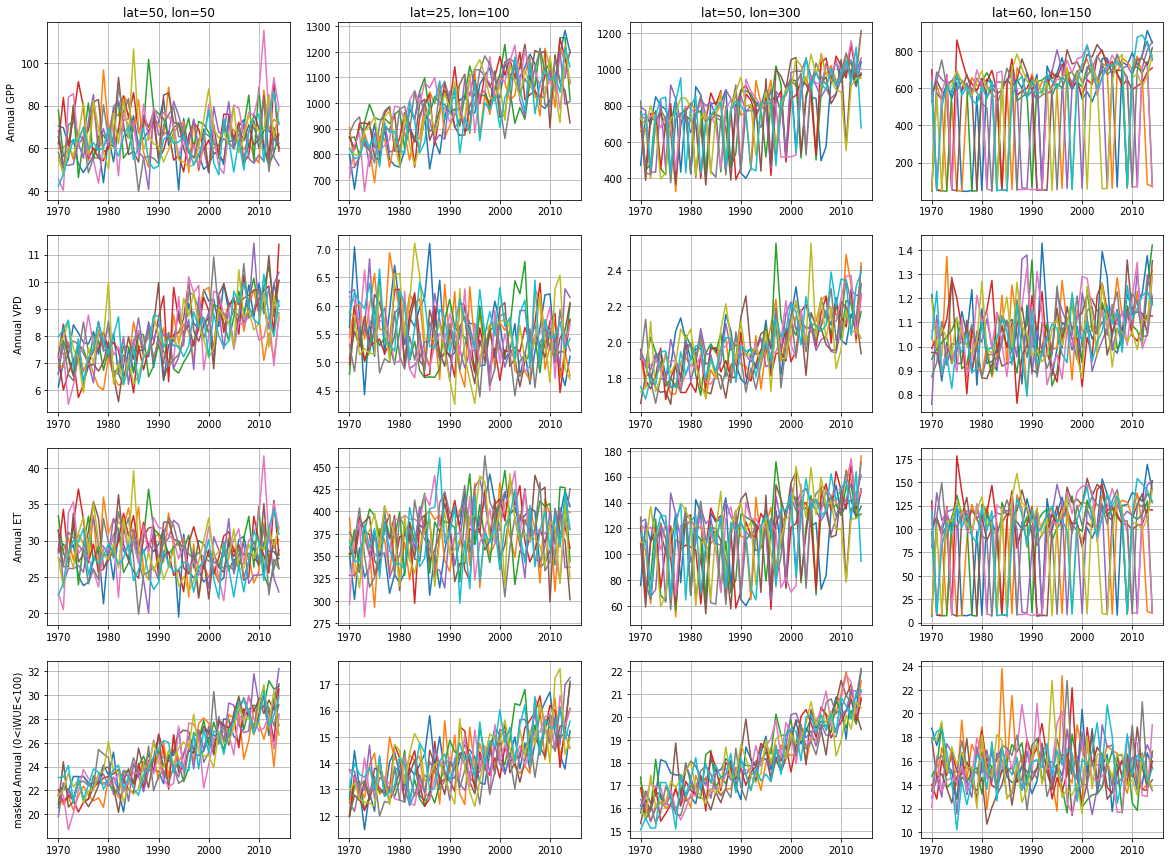

In [26]:
lats = [50,25 ,50 ,60 ] # 1=low porductivity, 2='normal GPP, declining VPD', 
                        #3 = very low productivity years, 5 = SUPER low productivity years [snow covered]
lons = [50,100,300,150]   # evidence for negative WUE in Arctic?
plotVars = ['GPP','VPD', 'ET','iWUE2'] #, 'iWUE'

nrows = len(plotVars)
ncols = len(lats)
plt.figure(figsize=[20,15])
p = 1
for j in range(len(plotVars)):
    for i in range(len(lats)):
        plt.subplot(nrows,ncols,p)
        plt.plot(ann_grid[plotVars[j]].year, 
                 ann_grid[plotVars[j]].sel(lat=lats[i], lon=lons[i], method='nearest'))
        plt.grid()
        if i == 0: plt.ylabel(ann_grid[plotVars[j]].attrs['long_name'])
        if j == 0: plt.title('lat='+str(lats[i])+', lon='+str(lons[i]));
        #if j == 4: plt.xlabel('year')
        p = p+1
plt.subplots_adjust(wspace=0.2);

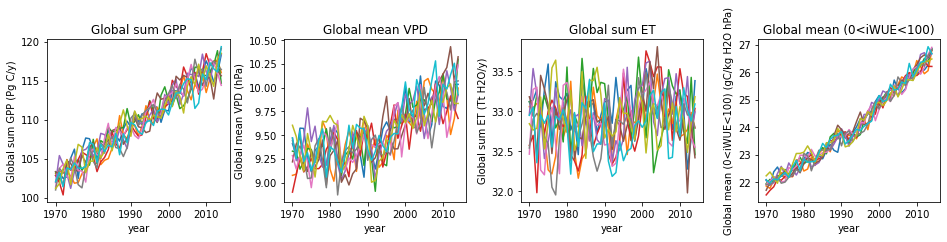

In [27]:
# Now plot global results from all ensemble members 
plotVars = ['GPP','VPD', 'ET','iWUE2']#, 'iWUE']
t = np.unique(ds['time.year'])
plt.figure(figsize=[16,3])

for i in range(len(plotVars)):
    plt.subplot(1,len(plotVars),(1+i))
    plt.title(ann[plotVars[i]].attrs['long_name'])
    plt.xlabel('year')
    plt.ylabel(ann[plotVars[i]].attrs['long_name']+' ('+ann[plotVars[i]].attrs['units']+')')
    for j in range(nens):
        plt.plot(t,ann[plotVars[i]].sel(ens=j))

plt.subplots_adjust(wspace=0.3);

### Look at gridded annual values

In [28]:
#ann_grid['VPD'].where(landarea>0).isel(ens=1,year=1).plot(robust=True);

------------------
## Calculate linear trends in each grid & ensemble
#### Define functions to:
- calculate slope and 
- wrap calculations for gridded data

In [29]:
# From LENS1 example https://github.com/NCAR/cesm-lens-aws/blob/master/notebooks/kay-et-al-2015.v3.ipynb
def linear_trend(da, dim="year"):
    da_chunk = da.chunk({dim: -1})
    trend = xr.apply_ufunc(
        calc_slope,
        da_chunk,
        vectorize=True,
        input_core_dims=[[dim]],
        output_core_dims=[[]],
        output_dtypes=[np.float],
        dask="parallelized",
    )
    return trend


def calc_slope(y):
    """ufunc to be used by linear_trend"""
    x = np.arange(len(y))

    # drop missing values (NaNs) from x and y
    finite_indexes = ~np.isnan(y)
    slope = (
        np.nan
        if (np.sum(finite_indexes) < 2)
        else np.polyfit(x[finite_indexes], y[finite_indexes], 1)[0]
    )
    return slope

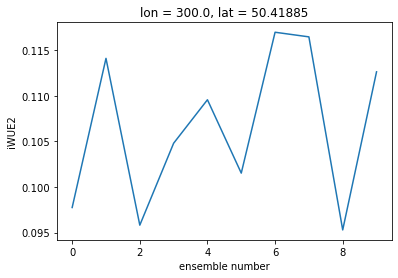

In [30]:
# test at a single grid cell
test = linear_trend(ann_grid['iWUE2'].sel(lat=50, lon=300, method='nearest'))
test.plot();

In [31]:
# Linear trends everywhere!
WUE_trends = linear_trend(ann_grid['iWUE2'].chunk({"lat": 20, "lon": 20, "year": -1}) ) 
trends = xr.Dataset(coords=WUE_trends.coords)

for i in range(len(plotVars)):
    trends[plotVars[i]] = linear_trend(ann_grid[plotVars[i]].chunk({
        "lat": 20, "lon": 20, "year": -1}).where(landarea>0) ) 
    trends[plotVars[i]].attrs['long_name'] = plotVars[i]+' trend'
    trends[plotVars[i]].attrs['units'] = ann_grid[plotVars[i]].attrs['units']+' per year'

trends_mean = trends.mean(dim='ens')#.compute(skipna=True)
trends_std = trends.std(dim='ens')#.compute(skipna=True)

print('-- finished calculating trends -- ')

-- finished calculating trends -- 


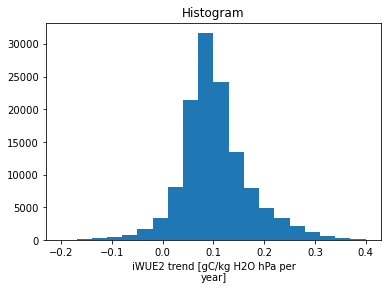

In [33]:
trends.iWUE2.where(landarea>0,np.nan).plot.hist(range=[-0.2,0.4],bins=20) ;

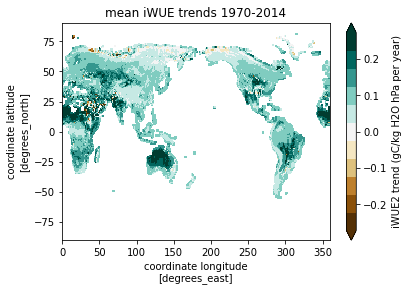

In [32]:
# Plot mean trends across ensembles
trends_mean['iWUE2'].plot(robust=True, cmap=ccc,
    cbar_kwargs={"label": trends['iWUE2'].attrs['long_name']+' ('+
                 trends['iWUE2'].attrs['units']+')'})
plt.title('mean iWUE trends 1970-2014');

## Trends are much weaker than reported by Keenan et al. 2013.
- Maybe because we're looking at full year, not just growing season?

In [34]:
# Create mask for significant trends
sigMask = xr.ufuncs.fabs(trends_mean) - 2*(trends_std)

### Define mapping function for global plots 

In [53]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# Generate a function for making panel plots of maps
def map_function(da, cb=0, panel=None, cmap=None, ax=None, 
                 title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,-65,80], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.00, 1.00), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # allows for different colorbars on each plot
    if cb == 1:
        fig.colorbar(im, ax=ax,shrink=0.50, pad=0, fraction = 0.05)

#### Now call the map_function to look at trends

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


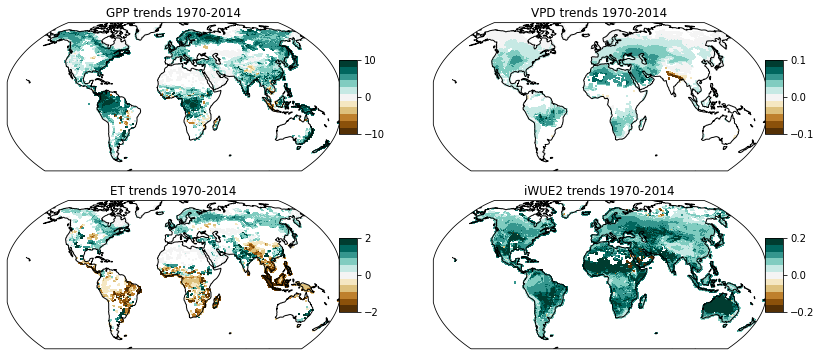

In [54]:
plotVars = ['GPP','VPD','ET','iWUE2']#, 'iWUE']
vmax     = [ 10  , 0.1 , 2  , 0.2]
vmin     = [-10  ,-0.1 ,-2  ,-0.2]
# --------------
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
i = 0
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = trends_mean[plotVars[i]].where(sigMask[plotVars[i]]>0)
    title=plotVars[i]+' trends '+ str(ann_grid.year[0].values) + '-'+ str(ann_grid.year[-1].values) 
    #cmap=ccc
    map_function(da, ax=ax, title=title,cmap=ccc,vmax=vmax[i], vmin=vmin[i],cb=1)
    i = i+1   

In [55]:
#tVar = 'ET'
#trends_mean[tVar].where(sigMask[tVar]>0).plot(robust=True, #cmap=ccc,
#    cbar_kwargs={"label": trends[tVar].attrs['long_name']+' ('+
#                 trends[tVar].attrs['units']+')'})
#plt.title('significant mean '+tVar+' trends 1970-2014');

In [56]:
#WUE_trends.min(dim='ens').plot(robust=True, cmap=ccc) ;

### short_trends, look at last 25 years, more comparable to Keenan's paper

In [62]:
# Linear trends everywhere!
short_trends = xr.Dataset(coords=trends.coords) 

for i in range(len(plotVars)):
    short_trends[plotVars[i]] = linear_trend(ann_grid[plotVars[i]].isel(year=slice(-25,None)).chunk({
        "lat": 20, "lon": 20, "year": -1}).where(landarea>0) )#.load() 
    short_trends[plotVars[i]].attrs['long_name'] = plotVars[i]+' trend'
    short_trends[plotVars[i]].attrs['units'] = ann_grid[plotVars[i]].attrs['units']+' per year'

short_trends_mean = short_trends.mean(dim='ens')#.compute(skipna=True)
short_trends_std = short_trends.std(dim='ens')#.compute(skipna=True)

# Create mask for significant trends
short_sigMask = xr.ufuncs.fabs(short_trends_mean) - 2*(short_trends_std)

print('-- finished calculating short_trends -- ')

-- finished calculating short_trends -- 


In [68]:
fyear = (str(ann_grid.isel(year=slice(-25,None)).year[0].values))
lyear = (str(ann_grid.isel(year=slice(-25,None)).year[-1].values))

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


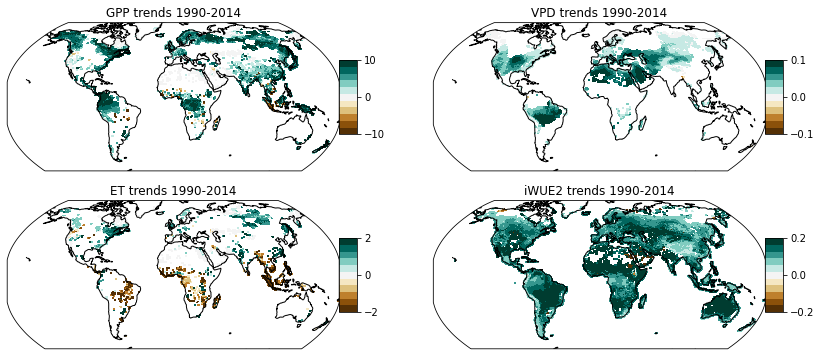

In [69]:
# --------------
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
i = 0
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = short_trends_mean[plotVars[i]].where(short_sigMask[plotVars[i]]>0)
    title=plotVars[i]+' trends '+ fyear + '-'+ lyear
    #cmap=ccc
    map_function(da, ax=ax, title=title, cmap=ccc,vmax=vmax[i], vmin=vmin[i],cb=1)
    i = i+1   
    

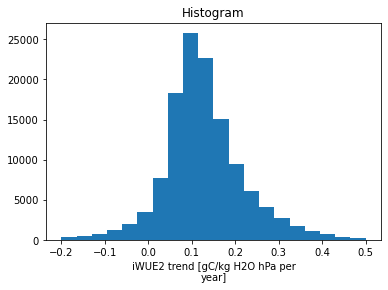

In [71]:
short_trends.iWUE2.where(landarea>0,np.nan).plot.hist(range=[-0.2,0.5],bins=20) ;

### iWUE = (ca * Ci)/1.6
- from Keenan et al, eq8 
- ca = ambient mole fraction CO2, can get from CO2 forcing file
- Ci = canopy integrated concentration of intercellular CO2
### Ci = ca - iWUE/1.6

In [ ]:
#client.close()

In [ ]:
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`